# Lab 4
# Kevin Liang - kgl392
# Matthew Tan - mmt2338

In [191]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import math
import sympy
import scipy
import urllib2
import urllib
from bs4 import BeautifulSoup
import pdfminer
from cStringIO import StringIO
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from sklearn.feature_extraction.text import CountVectorizer
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from collections import Counter
import random
from mpl_toolkits.mplot3d import Axes3D
import pylab as pl
import collections
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

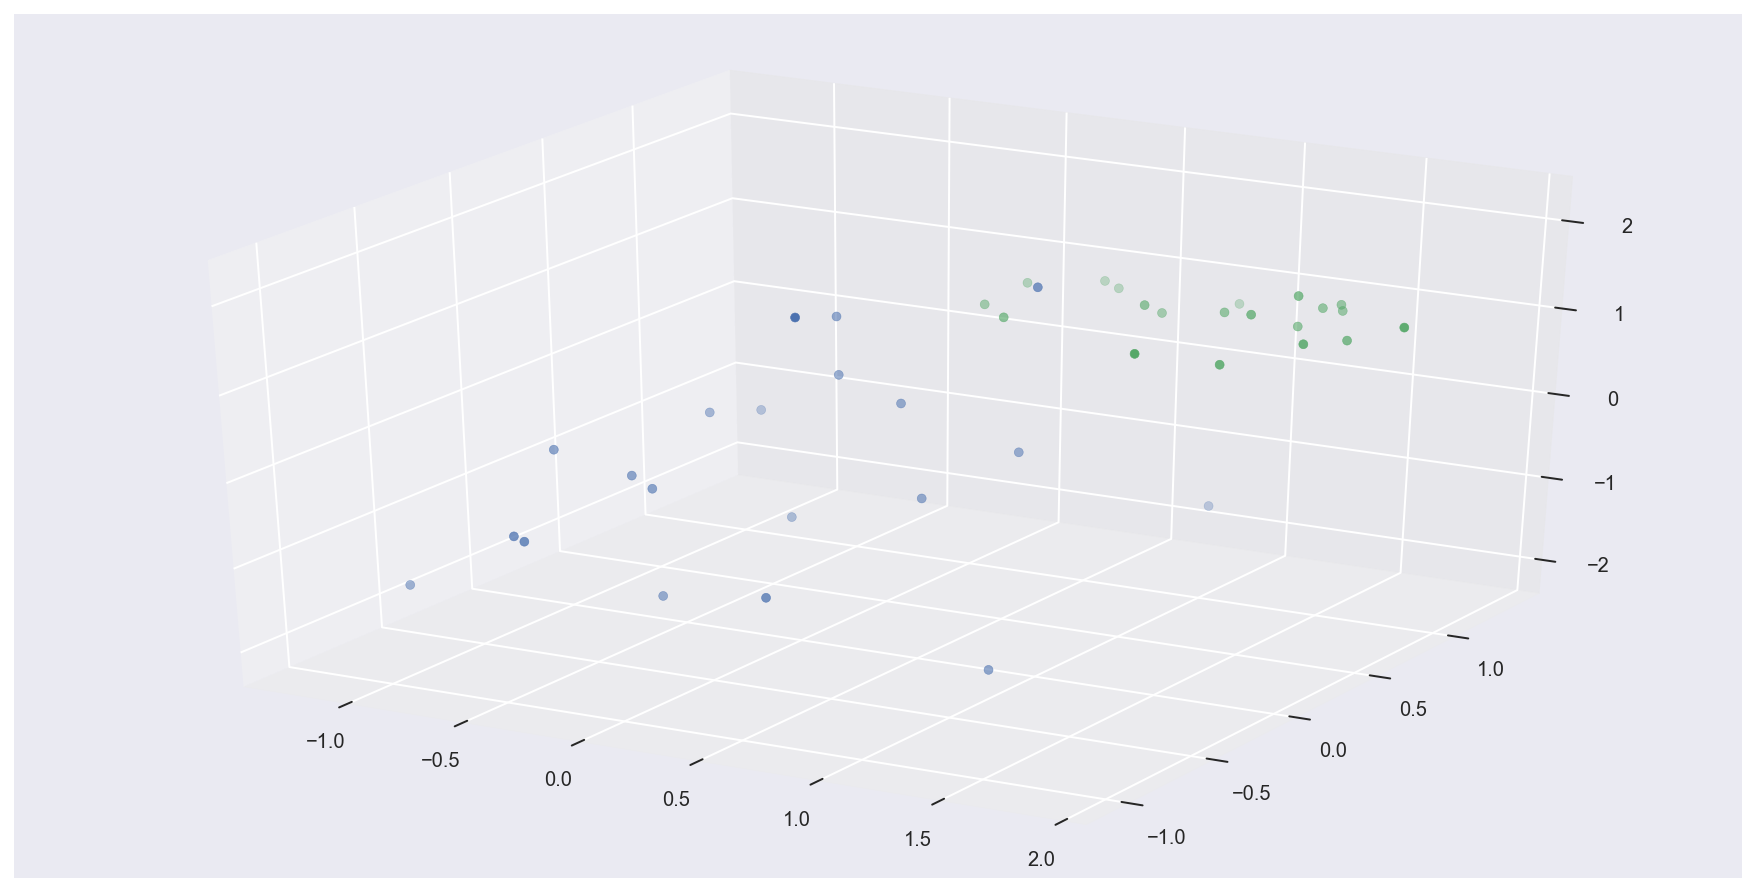

'\nBlue points seem to be more spread out, while the green points seem \nto be clustered closer together specifically on the Z axis.\nThis is because the variance of the Z variable in the covariance matrix for\ndistribution_1 is closer to 0 than the variance of the Z variable for \ndistribution_0. A smaller variance means the data is less likely to vary from the mean,\nresulting in a more clustered set of data along that axis. \n'

In [192]:
# Question 1 - Part 1

distribution_0 = np.random.multivariate_normal([0,0,0], [[0.5,0,0],[0,0.5,0],[0,0,0.7]], 20)
distribution_1 = np.random.multivariate_normal([1,1,1],[[0.5,0,0],[0,0.05,0],[0,0,0.01]], 20)

#print distribution_0, distribution_1
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(distribution_0[:,0], distribution_0[:,1], distribution_0[:,2])
ax.scatter(distribution_1[:,0], distribution_1[:,1], distribution_1[:,2])
plt.show()

# Blue points are distribution_0
# Green points are distribution_1

# Question 1 - Part 2

"""
Blue points seem to be more spread out, while the green points seem 
to be clustered closer together specifically on the Z axis.
This is because the variance of the Z variable in the covariance matrix for
distribution_1 is closer to 0 than the variance of the Z variable for 
distribution_0. A smaller variance means the data is less likely to vary from the mean,
resulting in a more clustered set of data along that axis. 
"""

In [193]:
# Question 1 - Part 3

def cov(a, b, mean_a, mean_b):
    numerator_sum = 0
    for x in range(len(a)):
        numerator_sum += (a[x] - mean_a)*(b[x] - mean_b)
    return float(numerator_sum)/float(len(a)-1)
        

distribution_concat = np.concatenate((distribution_0, distribution_1),axis = 0)
xp = distribution_concat[:,0]
yp = distribution_concat[:,1]
zp = distribution_concat[:,2]
mean_x = np.mean(xp)
mean_y = np.mean(yp)
mean_z = np.mean(zp)
var_x = np.var(xp)
var_y = np.var(yp)
var_z = np.var(zp)


        
# print mean_x, mean_y, mean_z, var_x, var_y, var_z
cov_xy = cov(xp,yp,mean_x,mean_y)
cov_xz = cov(xp,zp,mean_x,mean_z)
cov_yz = cov(yp,zp,mean_y,mean_z)

covariance_array = [[var_x,cov_xy,cov_xz],[cov_xy,var_y,cov_yz],[cov_xz,cov_yz,var_z]]

print np.matrix(covariance_array)

[[ 0.60029398  0.32976606  0.46094052]
 [ 0.32976606  0.47296789  0.34732461]
 [ 0.46094052  0.34732461  1.09326052]]


In [194]:
# Question 1 - Part 4

def largest_two(a):
    mn = 999999999999
    min_index = 0
    for x in range(len(a)):
        if mn > a[x]:
            min_index = x
            mn = a[x]
    return [x for x in range(len(a)) if x != min_index]
    
# find eigenvalues and eigenvectors
eigen = np.linalg.eig(covariance_array)
"""
print "eigenvalues"
print eigen[0]
print "eigenvector"
print eigen[1]
"""
eigen_values = eigen[0]
eigen_vectors = np.transpose(eigen[1])

# find max 2 values
index_largest_2 = largest_two(eigen_values)
evals = [eigen_values[x] for x in index_largest_2]
evects = np.array([eigen_vectors[:,x] for x in index_largest_2])

# center the data
for kek in range(len(xp)):
    distribution_concat[kek,0] = (distribution_concat[kek,0] - mean_x)/float(math.sqrt(var_x))
    distribution_concat[kek,1] = (distribution_concat[kek,1] - mean_y)/float(math.sqrt(var_y))
    distribution_concat[kek,2] = (distribution_concat[kek,2] - mean_z)/float(math.sqrt(var_z))


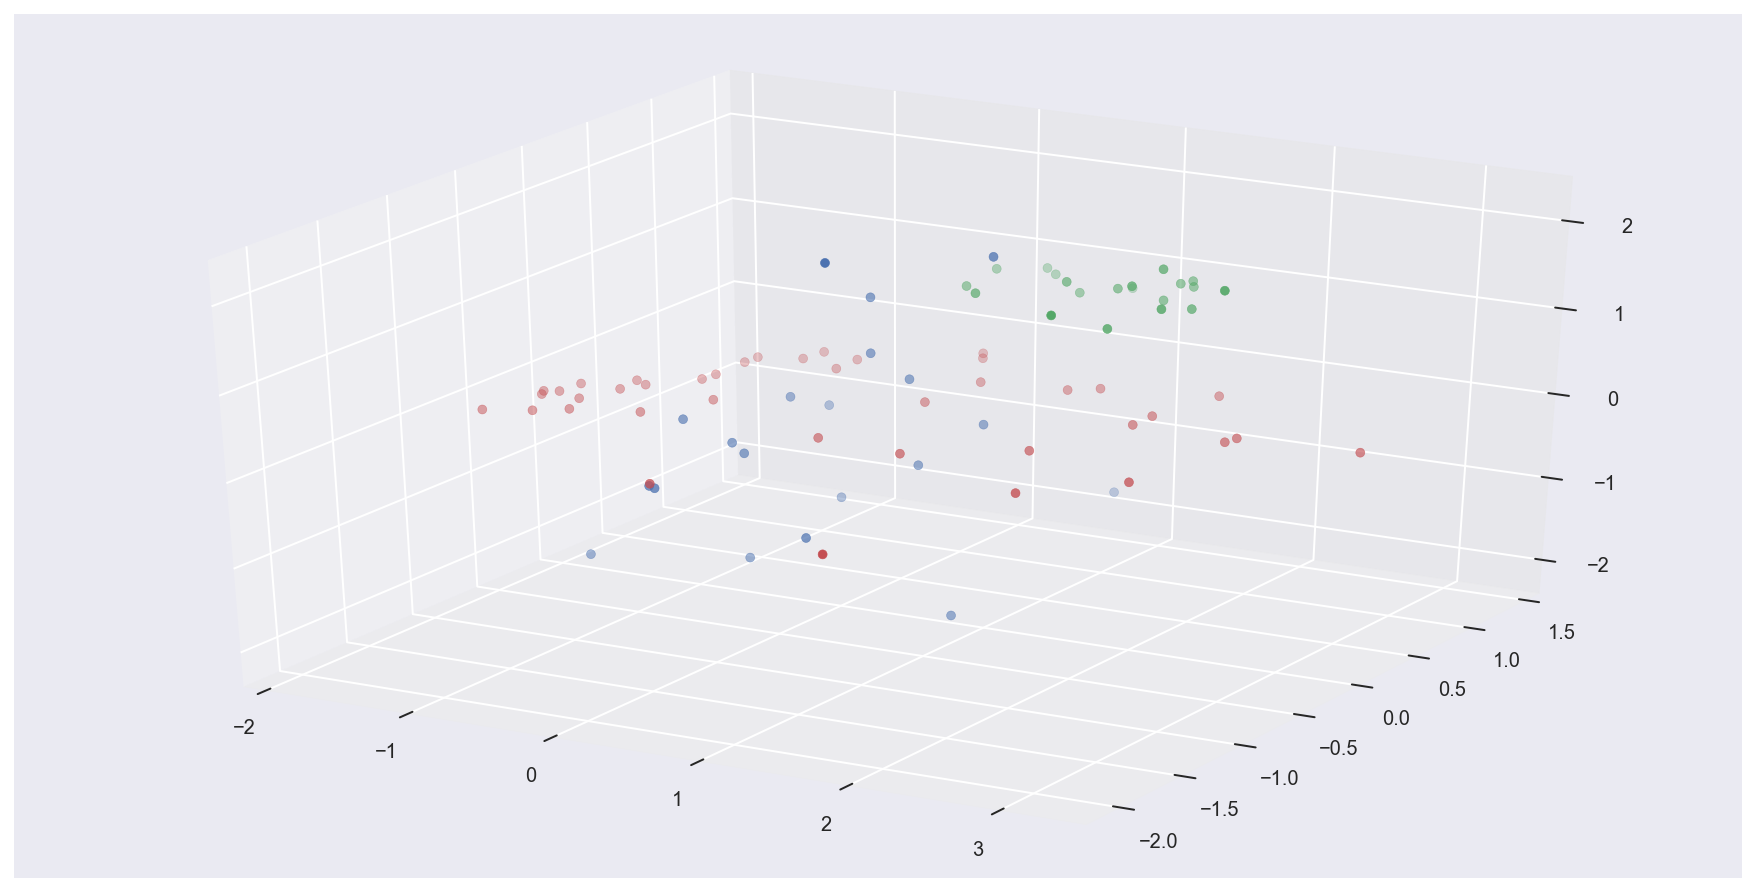

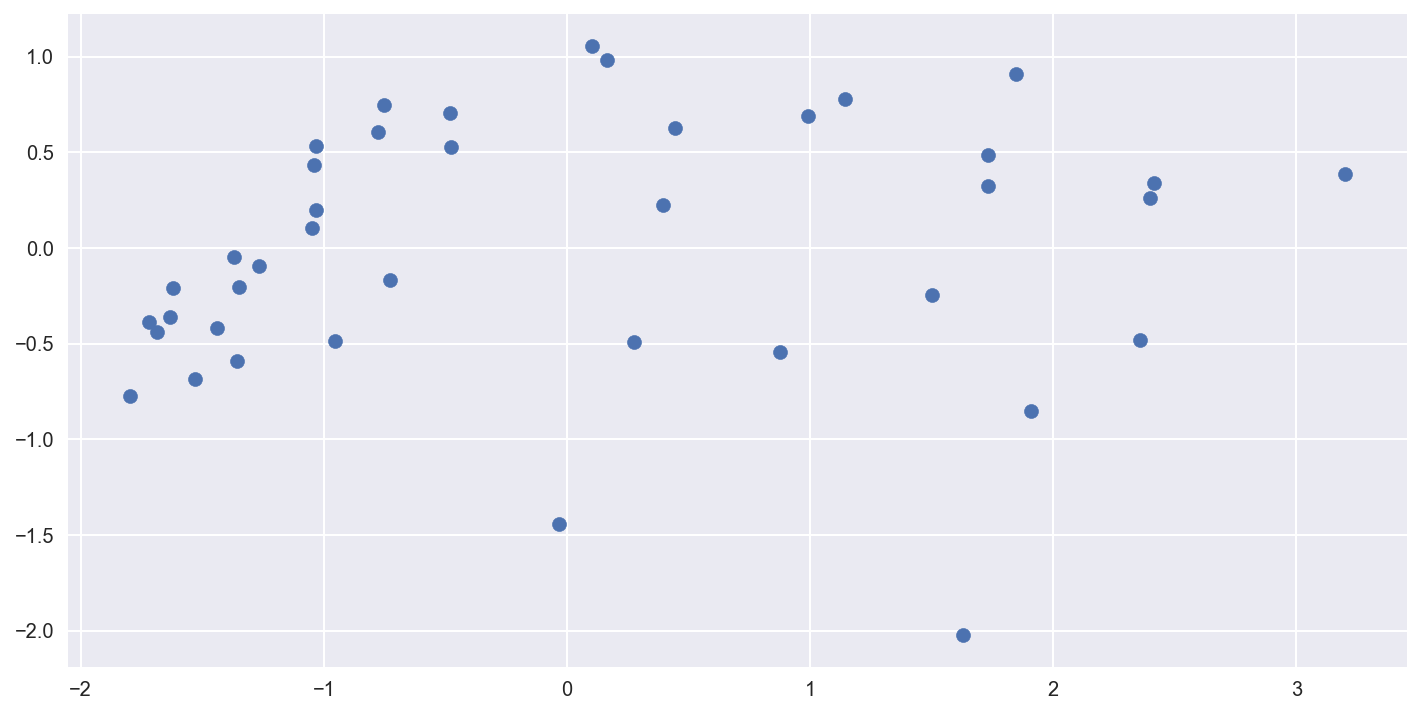

'\nPCA allowed us to identify the 2 components (dimensions) with the highest variance'

In [195]:
# Question 1 - Part 4
# calculate and plot the data
transposed_distribution = np.transpose(distribution_concat)

new_data = np.dot(evects,transposed_distribution)
transposed_new_data = np.transpose(new_data)
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(distribution_0[:,0], distribution_0[:,1], distribution_0[:,2])
ax.scatter(distribution_1[:,0], distribution_1[:,1], distribution_1[:,2])
ax.scatter(transposed_new_data[:,0], transposed_new_data[:,1])
plt.show()

plt.scatter(transposed_new_data[:,0], transposed_new_data[:,1])
plt.show()

"""
PCA allowed us to identify the 2 components (dimensions) with the highest variance"""

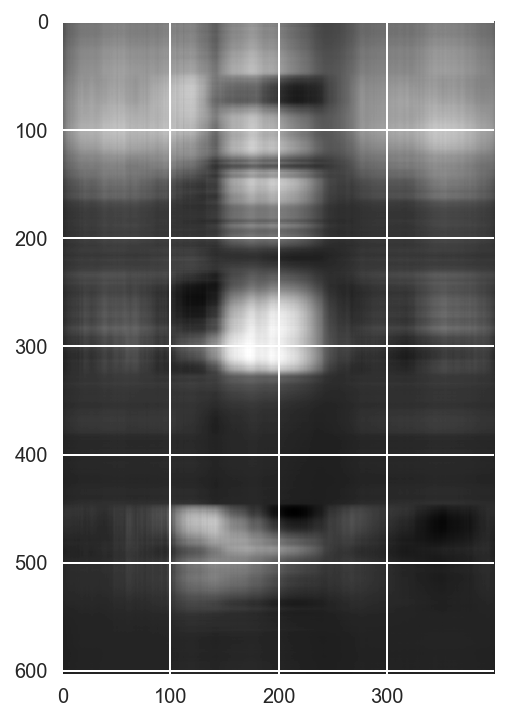

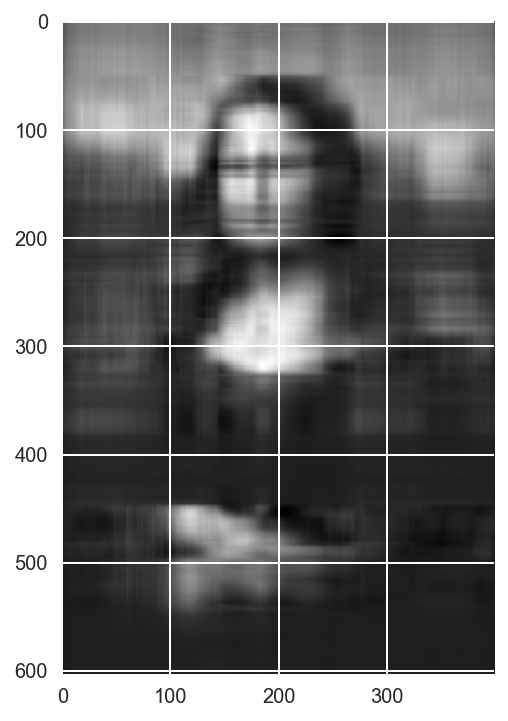

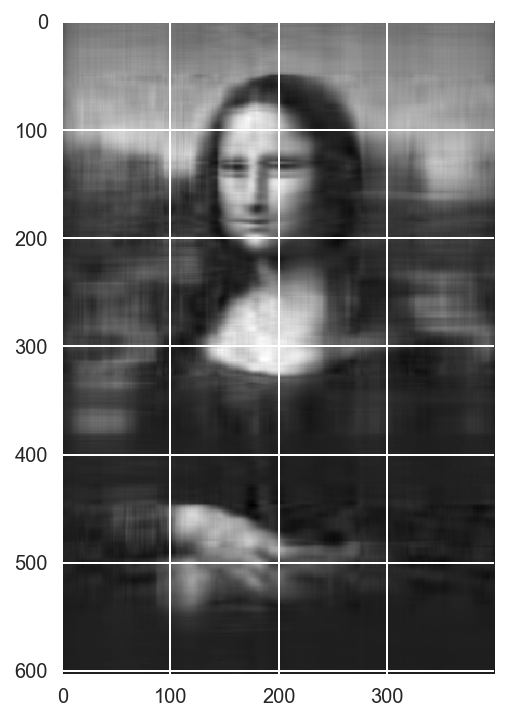

Number of Bits with k = 2: 603*400*(2/400)*16 = 19296.0
Number of Bits with k = 5: 603*400*(5/400)*16 = 48240.0
Number of Bits with k = 10: 603*400*(10/400)*16 = 96480.0


In [196]:
# Question 2 - Part 1

image = scipy.misc.imread("D:/Kevin Liang/Documents/1_UT_SENIOR/UT_AUSTIN_FALL_2017/EE_379K/Lab4/mona_lisa.png", flatten = True)

length = image.shape[0]
width = image.shape[1]

# calculate singular value decomp of the image
U, svd, Vt = np.linalg.svd(image)

# construct sigma matrix from singular to a matrix of size of the image
app = scipy.linalg.diagsvd(svd, image.shape[0], image.shape[1])

k_vals = [2,5,10]

for k in k_vals:
    temp_app = app.copy()
    temp_app[temp_app < svd[int(k)]] = 0
    
    # calculate low rank approx matrix
    x = np.dot(np.dot(U,temp_app),Vt)

    
    # plot the image
    pl.gray()
    pl.imshow(x)
    pl.show()
    
print "Number of Bits with k = 2: " + str(length) + "*" + str(width) + "*" + "(2/" + str(width) + ")*16 = " + str(length*width*float(2/float(width))*16)
print "Number of Bits with k = 5: " + str(length) + "*" + str(width) + "*" + "(5/" + str(width) + ")*16 = " + str(length*width*float(5/float(width))*16)
print "Number of Bits with k = 10: " + str(length) + "*" + str(width) + "*" + "(10/" + str(width) + ")*16 = " + str(length*width*float(10/float(width))*16)

In [197]:
# Question 3
"""
To identify corrupt entries I first reduced the dimension of the data using PCA to 2 dimensions.
The amount of variance is greater than 85% for both datasets for 2 dimensions.
For each of the features, the mean and standard deviation was calculated.
An outlier was defined as a point with a value greater than 2 standard deviations from the dimension with the lower variance.
This was done to unsure that the data was not "over corrected". 
A linear best fit line was then calculated with the outlier points removed. 
The outlier points were then scaled to new points by the best fit line.
These new points as well as the old non-outlier points were then graphed together to produce a new graph with corrupt entries corrected."""

'\nTo identify corrupt entries I first reduced the dimension of the data using PCA to 2 dimensions.\nThe amount of variance is greater than 85% for both datasets for 2 dimensions.\nFor each of the features, the mean and standard deviation was calculated.\nAn outlier was defined as a point with a value greater than 2 standard deviations from the dimension with the lower variance.\nThis was done to unsure that the data was not "over corrected". \nA linear best fit line was then calculated with the outlier points removed. \nThe outlier points were then scaled to new points by the best fit line.\nThese new points as well as the old non-outlier points were then graphed together to produce a new graph with corrupt entries corrected.'

Total Variance Capture: 0.849667232124


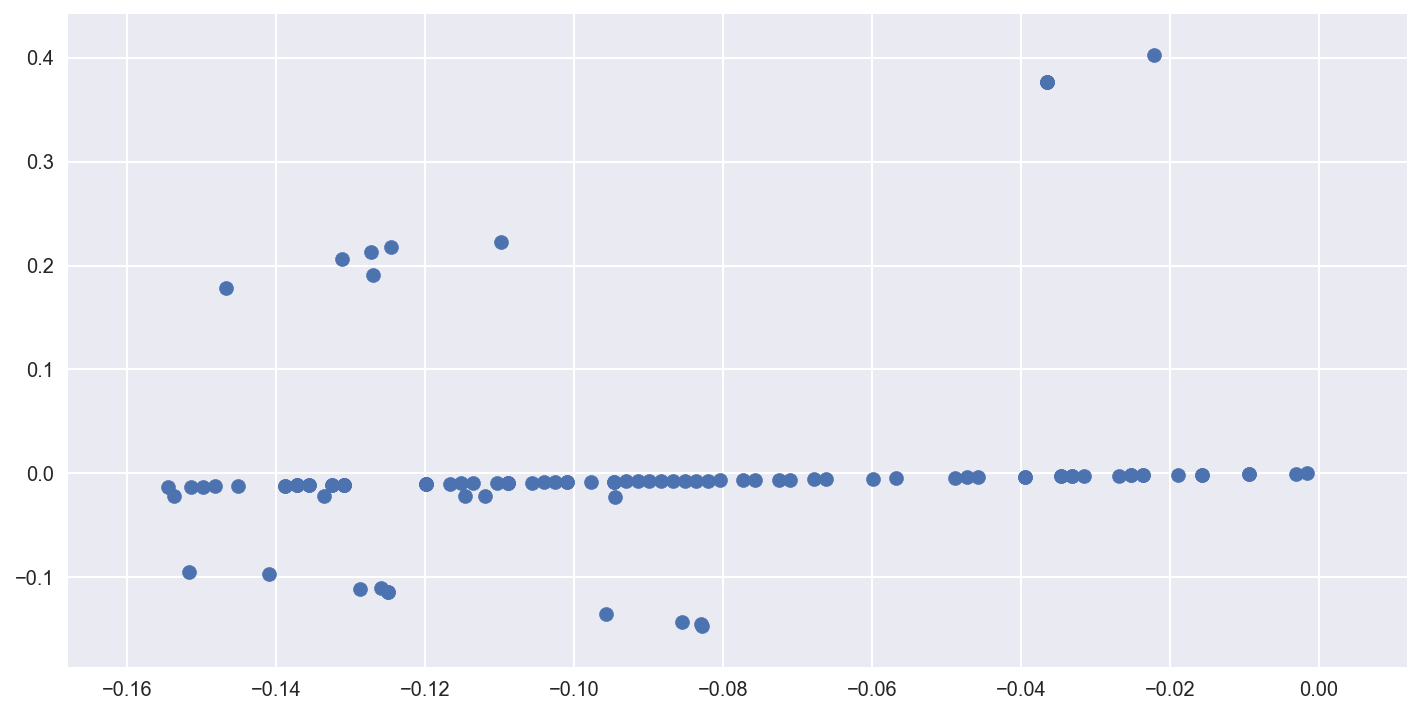

0.0973895101746 0.000301706336669


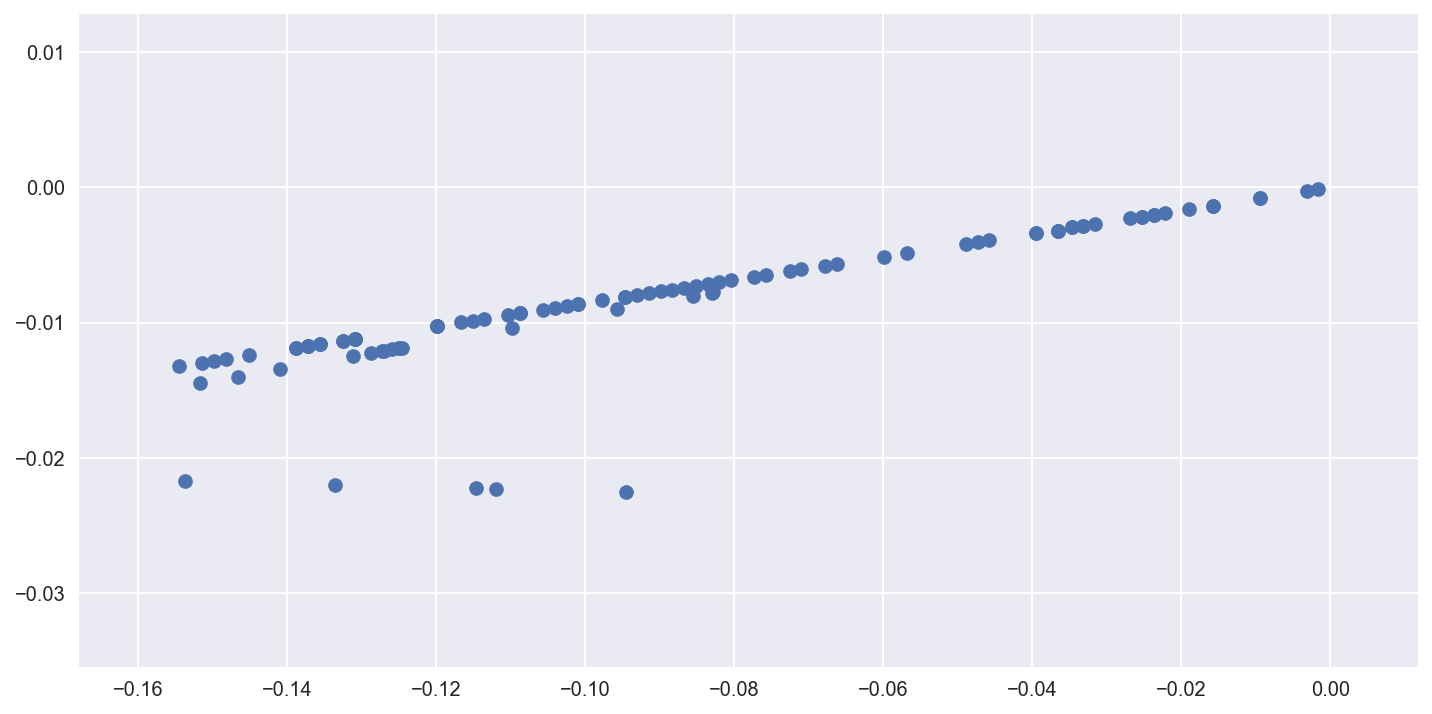

In [198]:
# Question 3
def xy(a):
    x = []
    y = []
    for _ in range(len(a)):
        x.append(a[_][0])
        y.append(a[_][1])
    return x,y

from sklearn.decomposition import PCA
path = "D:/Kevin Liang/Documents/1_UT_SENIOR/UT_AUSTIN_FALL_2017/EE_379K/Lab4/"
data = pd.read_csv(path + "CorrMat1.csv")

components = 2
pca = PCA(n_components = components)
pca.fit(data)
print "Total Variance Capture: " + str(sum(pca.explained_variance_ratio_[:2]))
plt.scatter(pca.components_[0], pca.components_[1])
plt.show()

means = []
std = []

# find mean and std for feature
for feature in pca.components_:
    means.append(np.mean(feature))
    std.append(np.std(feature))

outliers = []
non_outliers = []

pca_transformed = [list(l) for l in zip(pca.components_[0], pca.components_[1])]

# find outliers and non outliers
for point in pca_transformed:
    if point[1] < means[1] + std[1] and point[1] > means[1] - std[1]:
        non_outliers.append(point)
    else:
        outliers.append(point)
        
#print outliers
non_outliers_x, non_outliers_y = xy(non_outliers)


#print non_outliers
poly_fit = np.polyfit(non_outliers_x, non_outliers_y, 1)


# scale outliers to line of best fit
outliers_gone_good = []

for point in outliers:
    p = []
    p.append(point[0])
    p.append(point[0]*poly_fit[0] + poly_fit[1])
    outliers_gone_good.append(p)

print poly_fit[0], poly_fit[1]
non_outliers.extend(outliers_gone_good)
new_data = list(non_outliers)

#print new_data
x,y = xy(new_data)

plt.scatter(x, y)
plt.show()
    

Total Variance Capture: 0.920607773228


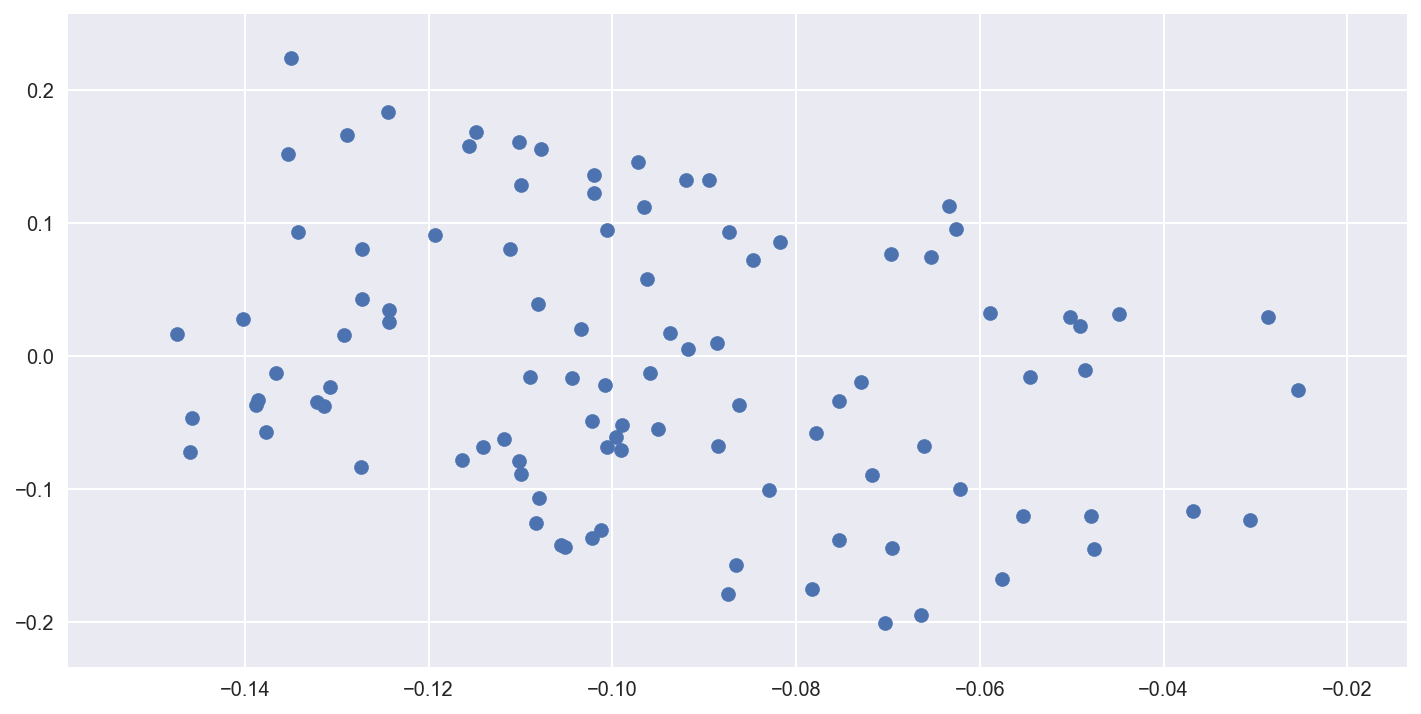

0.233953192871 0.00628911793773


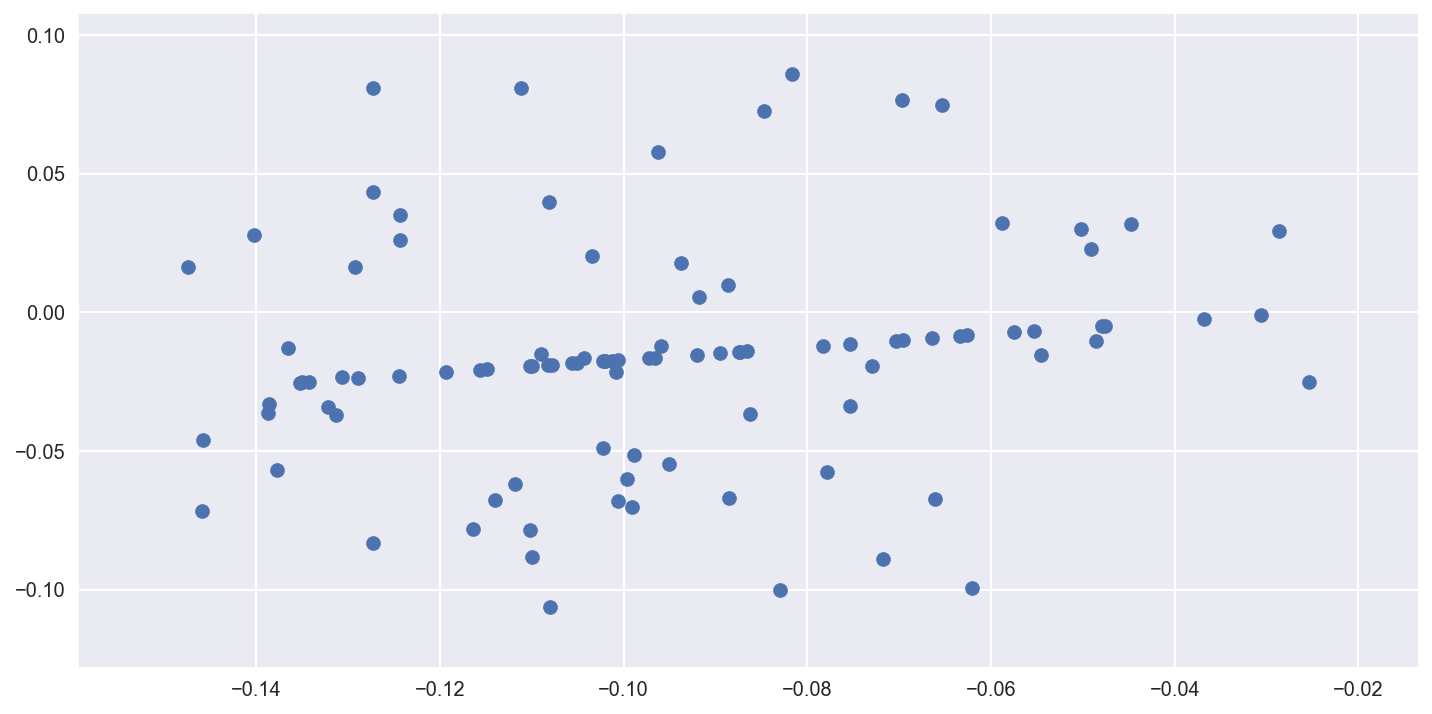

In [199]:
data = pd.read_csv(path + "CorrMat3.csv")
components = 2
pca = PCA(n_components = components)
pca.fit(data)
print "Total Variance Capture: " + str(sum(pca.explained_variance_ratio_[:2]))
plt.scatter(pca.components_[0], pca.components_[1])
plt.show()

means = []
std = []

# find mean and std for feature
for feature in pca.components_:
    means.append(np.mean(feature))
    std.append(np.std(feature))

outliers = []
non_outliers = []

pca_transformed = [list(l) for l in zip(pca.components_[0], pca.components_[1])]

# find outliers and non outliers
for point in pca_transformed:
    if point[1] < means[1] + std[1] and point[1] > means[1] - std[1]:
        non_outliers.append(point)
    else:
        outliers.append(point)
        
#print outliers
non_outliers_x, non_outliers_y = xy(non_outliers)


#print non_outliers
poly_fit = np.polyfit(non_outliers_x, non_outliers_y, 1)


# scale outliers to line of best fit
outliers_gone_good = []

for point in outliers:
    p = []
    p.append(point[0])
    p.append(point[0]*poly_fit[0] + poly_fit[1])
    outliers_gone_good.append(p)

print poly_fit[0], poly_fit[1]
non_outliers.extend(outliers_gone_good)
new_data = list(non_outliers)

#print new_data
x,y = xy(new_data)

plt.scatter(x, y)
plt.show()
    

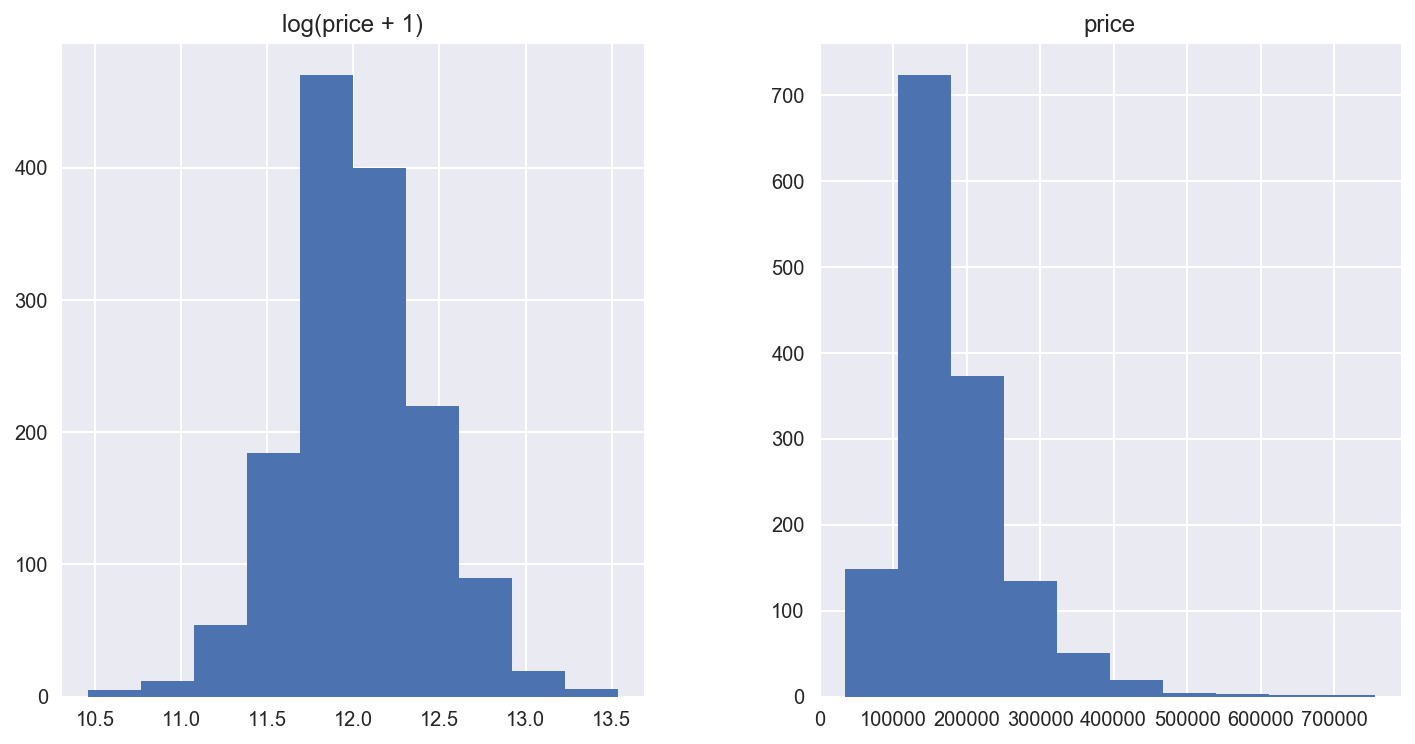

In [200]:
# Question 4 

# Pre processing
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.linear_model import Lasso, Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

# helper function to calculate rmse of a model
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

train = pd.read_csv("D:/Kevin Liang/Documents/1_UT_SENIOR/UT_AUSTIN_FALL_2017/EE_379K/Lab4/train.csv")
test = pd.read_csv("D:/Kevin Liang/Documents/1_UT_SENIOR/UT_AUSTIN_FALL_2017/EE_379K/Lab4/test.csv")

train.head()

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

all_data = pd.get_dummies(all_data)

#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice




Ridge Regresion Minimum Model Error: 0.127337346687
Lasso Regression Minimum Model Error: 0.12314421091


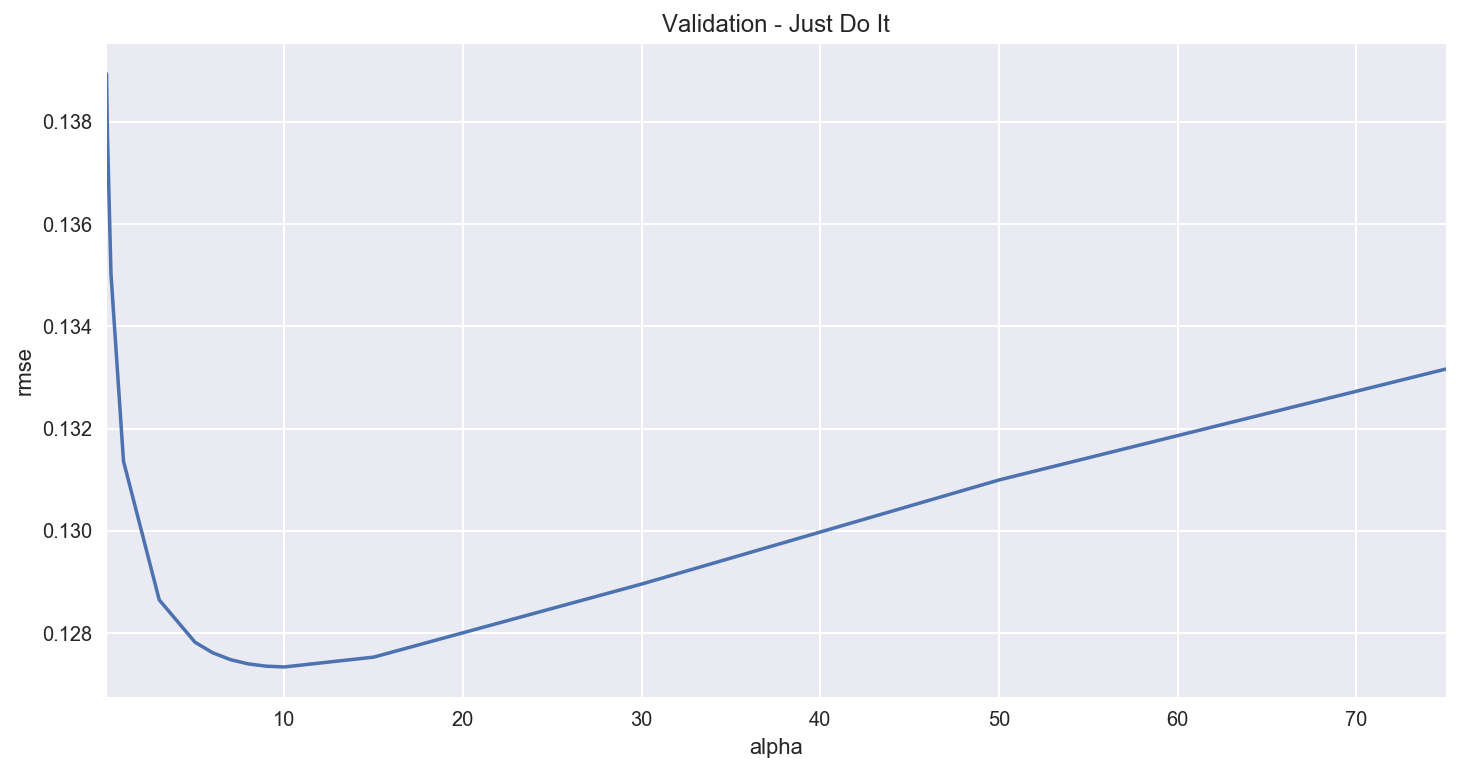

In [201]:
# Question 4 - Part 2

# Ridge Regression
model_ridge = Ridge()

alphas = [0.05, 0.1, 0.3, 1, 3, 5,6,7,8,9,10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

print "Ridge Regresion Minimum Model Error: " + str(cv_ridge.min())

# Lasso Regression

my_alphas = [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005]
model_lasso = LassoCV(alphas=my_alphas).fit(X_train, y)
lasso_predictions = model_lasso.predict(X_test)
print 'Lasso Regression Minimum Model Error: ' + str(rmse_cv(model_lasso).mean())




[280, 271, 258, 208, 178, 96, 67]


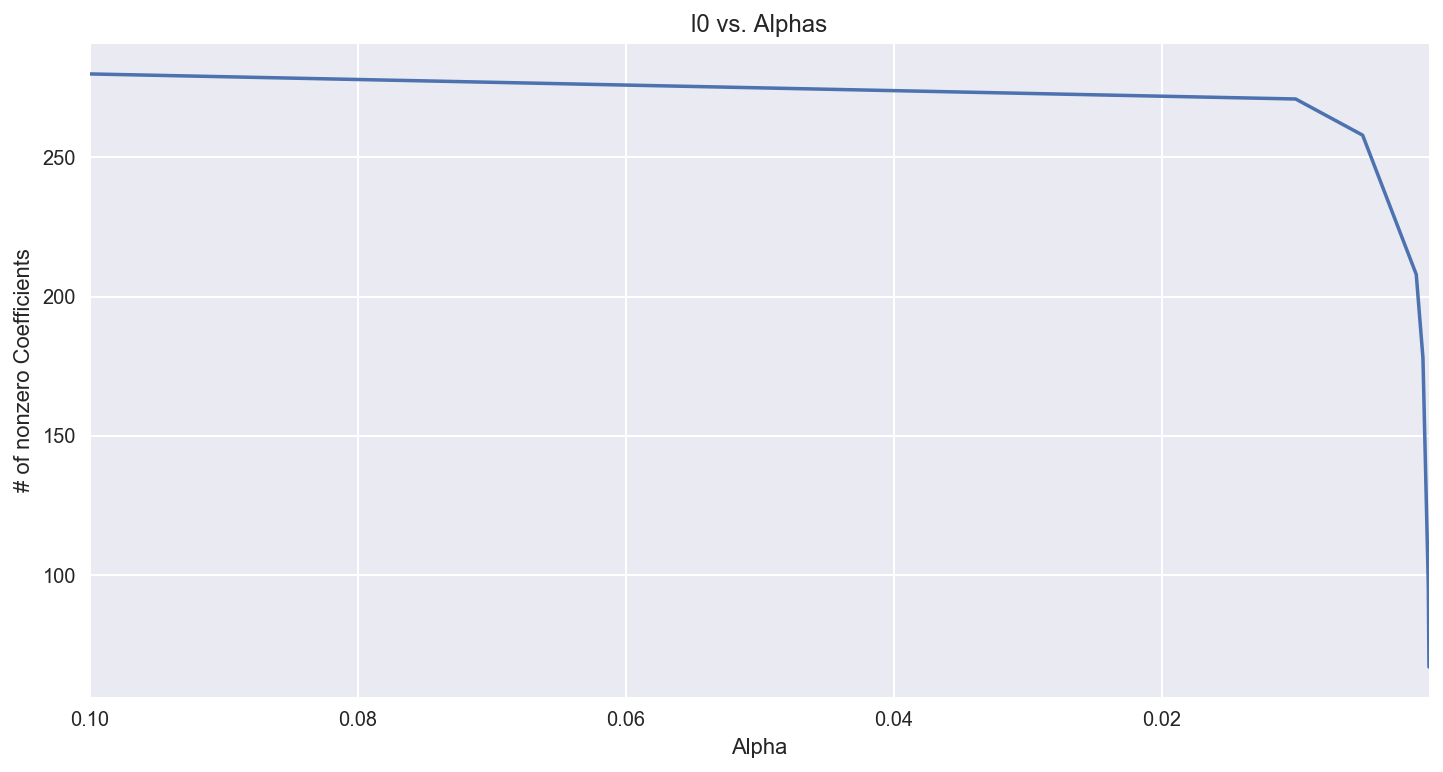

In [202]:
# Question 4 - Part 3

coefficients = []
coefficient_sums = []
for alpha in my_alphas:
    model_lasso = Lasso(alpha = alpha).fit(X_train,y)
    coef = pd.Series(model_lasso.coef_, index = X_train.columns)
    coefficients.append(coef)
    coefficient_sums.append(sum(coef == 0))

print coefficient_sums

# plot coefficients vs alphas
l_0 = pd.Series(coefficient_sums, index = my_alphas)
l_0.plot(title = "l0 vs. Alphas")
plt.xlabel("Alpha")
plt.ylabel("# of nonzero Coefficients")
plt.show()

In [203]:
# Question 4 - Part 5
parameters = {
    'max_depth':[1, 2, 6, 8, 10],
    'n_estimators':[25, 50, 100, 150, 200],
    'reg_alpha' : [0.001, 0.05, 0.1, 0.25, 0.5]
}

xgmodel = xgb.XGBRegressor()
xg_clf = GridSearchCV(xgmodel, parameters, cv = 5, scoring = "neg_mean_squared_error").fit(X_train, y)
print(np.sqrt(-xg_clf.best_score_))

xg_clf2 = RandomizedSearchCV(xgmodel, parameters, cv=5, scoring = "neg_mean_squared_error").fit(X_train, y)
print(np.sqrt(-xg_clf2.best_score_))

print(xg_clf.best_params_)
print(xg_clf2.best_params_)

0.126632423366
0.129122758854
{'n_estimators': 200, 'reg_alpha': 0.1, 'max_depth': 2}
{'n_estimators': 150, 'reg_alpha': 0.1, 'max_depth': 2}


In [204]:
# Question 4 - Part 4
# calculate prediction for ridge model with the least error
test_ridge = Ridge(alpha=10, solver='svd', tol=0.001).fit(X_train, y)
ridge_predictions = test_ridge.predict(X_test)

# add model predictions to training set and replace Nan's
X_train['Ridge Predictions'] = pd.Series(ridge_predictions, index=X_test.index)
X_train['Lasso Predictions'] = pd.Series(lasso_predictions, index=X_test.index)
X_train = X_train.fillna(X_train.mean())

# Train the ensemble model
ensemble_alphas = [0.01, 0.05, 0.1, 0.5, 1, 2, 4, 8, 10, 15, 30, 45, 60]
ensemble = [rmse_cv(Ridge(alpha=alpha, solver='svd', tol=0.001)).mean() for alpha in ensemble_alphas]
ensemble = pd.Series(ensemble, index = ensemble_alphas)
print 'Question 4 - Part 4 / Ensemble Ridge Regression Model: ' + str(ensemble.min())

# Question 4 - Part 6

# With Ridge results (Lasso Regression)
my_alphas = [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005]
ensemble = LassoCV(alphas=my_alphas).fit(X_train, y)
ensemble = pd.Series(ensemble, index = my_alphas)
print 'Ensemble Lasso Regression Model (with Ridge predictions) Error: ' + str(rmse_cv(model_lasso).mean())

# Without Ridge results (Lasso Regression)
X_train = X_train.drop('Ridge Predictions', axis=1) 
ensemble = LassoCV(alphas=my_alphas).fit(X_train, y)
ensemble = pd.Series(ensemble, index = my_alphas)
print 'Ensemble Lasso Regression Model (without Ridge predictions) Error: ' + str(rmse_cv(model_lasso).mean())

# Stacking Lasso results on original data (Ridge regression)
my_alphas = [0.01, 0.05, 0.1, 0.5, 1, 2, 4, 8, 10, 15, 30, 45, 60]
ensemble = [rmse_cv(Ridge(alpha=alpha, solver='svd', tol=0.001)).mean() for alpha in my_alphas]
ensemble = pd.Series(ensemble, index = my_alphas)
print 'Ensemble Ridge Regression Model (with many Lasso predictions) Error: ' + str(ensemble.min())

# Train a lasso regression model
my_alphas = [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005]
X_train = X_train.drop('Lasso Predictions', axis=1)
model_lasso = LassoCV(alphas=my_alphas).fit(X_train, y)
lasso_predictions = model_lasso.predict(X_test)
print 'Lasso Regression Model Error (without Lasso Predictions): ' + str(rmse_cv(model_lasso).mean())

# Convert solution to CSV
solution = pd.DataFrame({"id":test.Id, "SalePrice":pd.Series(lasso_predictions * 10000, index=X_test.index)})
solution.to_csv(path + "submission.csv", index = False)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Question 4 - Part 4 / Ensemble Ridge Regression Model: 0.127412121366
Ensemble Lasso Regression Model (with Ridge predictions) Error: 0.132292689195
Ensemble Lasso Regression Model (without Ridge predictions) Error: 0.132292556166
Ensemble Ridge Regression Model (with many Lasso predictions) Error: 0.12741038191
Lasso Regression Model Error (without Lasso Predictions): 0.12314421091


# Attempt 1: Run a Lasso Regression on the X_train data that has the a Ridge and Lasso prediction values included.

# Attempt 2: Run a Lasso Regression on the X_train data that has the Lasso prediction values included.

# Attempt 3: Run a Ridge Regression on the X_train data that has been run through multiple Lasso Regression Models.

# Attempt 4: Run  Lasso Regressional Model excluding the Lasso Prediction values. 

# Since a normal Lasso Regression Model demonstrates the smallest Error, we have stuck with the Lasso Regression Model as our best attempt.